### **Audience Rating Prediction for Rotten Tomatoes Movie Dataset**

#### **Steps Implemented:**

1. **Import Necessary Libraries:**
   - Importing required libraries such as pandas, numpy, sklearn, XGBoost, etc.

2. **Load Dataset:**
   - Load the Rotten Tomatoes movie dataset and convert it into a pandas DataFrame.

3. **Data Preprocessing:**
   - **Handle Missing Values / Imputation:**
     - Replace missing numerical values with the **mean** of the respective feature.
     - Replace missing textual values with `"Unknown"`.
     - Replace missing categorical values with `"NaN"`.
   
   - **Encode Categorical Features:**
     - For features with fewer unique values (e.g., `'rating'`, `'tomatometer_status'`), apply **One-Hot Encoding**.
     - For features with more unique values (e.g., `'genre'`, `'directors'`, etc.), apply **Frequency Encoding**.

   - **Generate Word Embeddings for Textual Features:**
     - For the feature `'movie_info'`, tokenize each sentence, remove stopwords, and generate **word embeddings** using the **Word2Vec model** with an embedding size of 10.

4. **Feature Extraction:**
   - **Sentiment Score:**
     - Create a new feature **"sentiment_score"** derived from `'critics_consensus'` using the **VADER sentiment analyzer**.

   - **Date Features:**
     - Extract the following date-related features from `'in_theaters_date'` and `'on_streaming_date'`:
       - `'in_theaters_year'`, `'in_theaters_month'`, `'in_theaters_day'`, `'in_theaters_weekday'`, `'in_theaters_is_weekend'`
       - `'on_streaming_year'`, `'on_streaming_month'`, `'on_streaming_day'`, `'on_streaming_weekday'`, `'on_streaming_is_weekend'`
       - **`'days_between'`** (the difference between `'in_theaters_date'` and `'on_streaming_date'`)

5. **Feature Selection Using Correlation Analysis:**
   - Calculate **Pearson correlation** of each numerical and categorical feature with the target column **`'audience_rating'`**.
   - Visualize the correlation matrix using a **bar chart**.
   
   - **Selected Features:**
     - Features with medium to high correlation with the target (`'audience_rating'`) are selected. These include:
       - `'runtime_in_minutes'`, `'tomatometer_rating'`, `'tomatometer_count'`
       - `'directors_Frequency'`, `'tomatometer_status_Certified Fresh'`, `'tomatometer_status_Fresh'`, `'tomatometer_status_Rotten'`
       - `'sentiment_score'`, `'in_theaters_year'`, `'in_theaters_weekday'`, `'on_streaming_year'`, `'days_between'`
       - Additionally, the **embeddings** of the `movie_info` and `critics_consensus` columns are selected.

6. **Normalization:**
   - The following columns are **normalized**:
     - `'runtime_in_minutes'`, `'tomatometer_rating'`, `'tomatometer_count'`, `'directors_Frequency'`, `'in_theaters_weekday'`, `'days_between'`.

7. **Model Training:**
   - **Data Split:**
     - Split the dataset into **training**, **validation**, and **test** sets.
   
   - **Model Selection:**
     - Three models are compared and evaluated:
       - **Linear Regression**
       - **Random Forest Regression**
       - **XGBoost Regression**
     - The model with the **least RMSE** and the **highest R-squared (R²)** value is selected, which is **XGBRegressor**.
   
   - **Hyperparameter Tuning:**
     - Use **Grid Search** to tune hyperparameters and find the best set of hyperparameters for the **XGBRegressor** model.

8. **Model Pipeline:**
   - Design the **model pipeline** using the best model and optimal hyperparameters.
   - Train the pipeline using the combined **training** and **validation** data.
   - Evaluate the model on the **test set** and calculate the performance metrics.

---

### **Final Evaluation on Test Dataset:**

- **Mean Squared Error (MSE):** `192.81`
- **Root Mean Squared Error (RMSE):** `13.89`
- **R-squared (R²):** `0.53`
- **Custom Testing Accuracy:** `75.86%`

---

### **Accuracy Calculation:**
The accuracy can be calculated using the **Mean Absolute Percentage Error (MAPE)** formula:

$$
\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left|\frac{\hat{yPred}_i - yActual_i}{yActual_i}\right| \times 100
$$


The **accuracy** is then calculated as:

$$
\text{Accuracy} = 100 - \text{MAPE}
$$

In this case, the accuracy is **75.86%**.


In [1]:
# 1. Import necessary libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from gensim.models import Word2Vec

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

In [2]:
# 2. Read the XLS file and convert to dataframes

file_path = "Rotten_Tomatoes_Movies3.xls"
df = pd.read_excel(file_path)
print(df.head())
print("Size:", df.shape)

                                         movie_title  \
0  Percy Jackson & the Olympians: The Lightning T...   
1                                        Please Give   
2                                                 10   
3                    12 Angry Men (Twelve Angry Men)   
4                       20,000 Leagues Under The Sea   

                                          movie_info  \
0  A teenager discovers he's the descendant of a ...   
1  Kate has a lot on her mind. There's the ethics...   
2  Blake Edwards' 10 stars Dudley Moore as George...   
3  A Puerto Rican youth is on trial for murder, a...   
4  This 1954 Disney version of Jules Verne's 20,0...   

                                   critics_consensus rating  \
0  Though it may seem like just another Harry Pot...     PG   
1  Nicole Holofcener's newest might seem slight i...      R   
2                                                NaN      R   
3  Sidney Lumet's feature debut is a superbly wri...     NR   
4  One of D

 #### **3. Data preprocessing:**

In [3]:
 # 3 a) Handle missing values/ Imputation:
 #       - Replace missing numerical values with mean of that feature
 #       - Replace missing data-time values with median of that feature
 #       - Replace missing textual values with "Unknown".
 #       - Replace missing categorical values with "NaN".


# Fill missing numeric columns with their mean
df['runtime_in_minutes'] = df['runtime_in_minutes'].fillna(df['runtime_in_minutes'].mean())
df['audience_rating'] = df['audience_rating'].fillna(df['audience_rating'].mean())

# Fill missing text columns with 'Unknown'
text_columns = ['movie_info', 'critics_consensus']
df[text_columns] = df[text_columns].fillna('Unknown')

# Fill missing categorical/object columns with 0
zero_fill_columns = ['genre', 'directors', 'writers', 'cast', 'studio_name']
df[zero_fill_columns] = df[zero_fill_columns].fillna(0)

# Convert columns to datetime format, coercing errors to NaT (Not a Time)
df['in_theaters_date'] = pd.to_datetime(df['in_theaters_date'], errors='coerce')
df['on_streaming_date'] = pd.to_datetime(df['on_streaming_date'], errors='coerce')

# Fill missing date values with their respective medians
df.fillna({
    'in_theaters_date': df['in_theaters_date'].median(),
    'on_streaming_date': df['on_streaming_date'].median()
}, inplace=True)

# Count of missing values per column
missing_values_per_column = df.isnull().sum()
print("Missing values per column:")
print(missing_values_per_column)

Missing values per column:
movie_title           0
movie_info            0
critics_consensus     0
rating                0
genre                 0
directors             0
writers               0
cast                  0
in_theaters_date      0
on_streaming_date     0
runtime_in_minutes    0
studio_name           0
tomatometer_status    0
tomatometer_rating    0
tomatometer_count     0
audience_rating       0
dtype: int64


In [4]:
# 3 b) Encode categorical features:
#    - Use one hot encoding for features with less number of unique values  - 'rating', 'tomatometer_status'
#    - use frequency encoding for features with more unique values - 'genre', 'directors', 'writers', 'cast', 'studio_name'

# Define the one-hot encoding function
def one_hot_encode(df, col):
    df = pd.get_dummies(df, columns=[col], dtype=int)
    return df

# Define the frequency encoding function
def frequency_encode(df, col):
    counts = df[col].value_counts()
    df[col + '_Frequency'] = df[col].map(counts)
    df = df.drop(col, axis=1)
    return df

# One-hot encode the 'rating' column
columns_to_onehot_encode = ['rating','tomatometer_status']
for col in columns_to_onehot_encode:
    df = one_hot_encode(df, col)

# Frequency encode the specified columns
columns_to_frequency_encode = ['genre', 'directors', 'writers', 'cast', 'studio_name']
for col in columns_to_frequency_encode:
    df = frequency_encode(df, col)


In [5]:
df.head()

,movie_title,movie_info,critics_consensus,in_theaters_date,on_streaming_date,runtime_in_minutes,tomatometer_rating,tomatometer_count,audience_rating,rating_G,...,rating_R,rating_R),tomatometer_status_Certified Fresh,tomatometer_status_Fresh,tomatometer_status_Rotten,genre_Frequency,directors_Frequency,writers_Frequency,cast_Frequency,studio_name_Frequency
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,2010-02-12,2010-06-29,83.0,49,144,53.0,0,...,0,0,0,0,1,6,13,1,1,414
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,2010-04-30,2010-10-19,90.0,86,140,64.0,0,...,1,0,1,0,0,1202,5,6,1,260
2,10,Blake Edwards' 10 stars Dudley Moore as George...,Unknown,1979-10-05,1997-08-27,118.0,68,22,53.0,0,...,1,0,0,1,0,257,27,6,1,1
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,1957-04-13,2001-03-06,95.0,100,51,97.0,0,...,0,0,1,0,0,191,30,2,1,110
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",1954-01-01,2003-05-20,127.0,89,27,74.0,1,...,0,0,0,1,0,26,16,1,1,26


In [6]:
# 3 c) Generate word embeddings for feature - 'movie_info'
#        - Tokenize each sentence and remove stopwords.
#        - Generate embedding vectors of size 10 using Word2Vec model.
           
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

#  Generate sentence embeddings
def get_sentence_embedding(tokens, model):
    # Average the word embeddings for each token
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)  # Mean vector for the sentence
    else:
        return np.zeros(model.vector_size)  # Fallback if no words are in the vocabulary
        
# remove stopwords from a single text entry
def remove_stopwords(text):
    words = nltk.word_tokenize(text)  # Tokenize the text
    filtered_words = [word for word in words if word.lower() not in stop_words]  # Remove stopwords
    return " ".join(filtered_words)  # Join the words back into a sentence

def generate_embeddings(df,col):
    df[col] = df[col].apply(remove_stopwords)
    
    # Tokenize the text into words
    df['tokens'] = df[col].apply(lambda x: word_tokenize(x.lower()))
    
    # Train Word2Vec on the tokenized data
    model = Word2Vec(sentences=df['tokens'], vector_size=10, window=5, min_count=1, workers=4, sg=0)  # sg=0 uses CBOW, sg=1 uses Skip-gram

    # Apply the embedding function
    df[col+'embedding'] = df['tokens'].apply(lambda x: get_sentence_embedding(x, model))
    
    # Convert embeddings to separate columns
    embedding_columns = [f"{col}_embedding_{i}" for i in range(model.vector_size)]
    embeddings_df = pd.DataFrame(df[col+'embedding'].tolist(), columns=embedding_columns)
    
    # Combine embeddings with the original DataFrame
    df_with_embeddings = pd.concat([df, embeddings_df], axis=1)
    
    # Drop intermediate columns
    df_with_embeddings.drop(['tokens', col+'embedding'], axis=1, inplace=True)
    
    return df_with_embeddings

# movie_info -------------------------------------------------------
df = generate_embeddings(df,'movie_info')

# # critics_consensus
# df = generate_embeddings(df,'critics_consensus')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Shano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shano\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### **4. Feature extraction:**

In [7]:
# 5 a) Create new feature "sentiment_score" from 'critics_consensus' embeddings using VADER sentiment analyzer.

# Apply sentiment analysis to the 'critic_consensus' column
def get_sentiment_score(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)  # Returns a dictionary with 'pos', 'neu', 'neg', and 'compound' scores
    return sentiment['compound']  # Returns only 'compound' score, which ranges from -1 to 1

df['sentiment_score'] = df['critics_consensus'].apply(lambda x: get_sentiment_score(str(x)))

In [8]:
#   5 b) Create following new features from 'in_theaters_date' and 'on_streaming_date' features
#            'in_theaters_year', 'in_theaters_month', 'in_theaters_day', 'in_theaters_weekday', 'in_theaters_is_weekend', 'on_streaming_year',   
# 'on_streaming_month', 'on_streaming_day', 'on_streaming_weekday', 'on_streaming_is_weekend', 'days_between'

   
# Feature extraction from 'in_theaters_date'
df['in_theaters_year'] = df['in_theaters_date'].dt.year
df['in_theaters_month'] = df['in_theaters_date'].dt.month
df['in_theaters_day'] = df['in_theaters_date'].dt.day
df['in_theaters_weekday'] = df['in_theaters_date'].dt.weekday  # 0 = Monday, 6 = Sunday
df['in_theaters_is_weekend'] = df['in_theaters_weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Feature extraction from 'on_streaming_date'
df['on_streaming_year'] = df['on_streaming_date'].dt.year
df['on_streaming_month'] = df['on_streaming_date'].dt.month
df['on_streaming_day'] = df['on_streaming_date'].dt.day
df['on_streaming_weekday'] = df['on_streaming_date'].dt.weekday
df['on_streaming_is_weekend'] = df['on_streaming_weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Calculate time difference between 'in_theaters_date' and 'on_streaming_date'
df['days_between'] = (df['on_streaming_date'] - df['in_theaters_date']).dt.days
df = df.drop('on_streaming_date', axis=1)
df = df.drop('in_theaters_date', axis=1)


In [9]:
# Save DataFrame as a CSV file
csv_file_path = "processed_dataset.csv"
df.to_csv(csv_file_path, index=False)  # index=False prevents saving the index as a column
print(f"Data saved as CSV at {csv_file_path}")

Data saved as CSV at processed_dataset.csv


In [10]:
# Drop the unnecessary processed columns
# movie_title is dropped as it is not understandable that it is not correlated to the rating

processed_df = df.drop(['movie_title','movie_info','critics_consensus'],axis=1)
print(processed_df.shape)

(16638, 42)


In [11]:
print("\nColumn Names:")
print(processed_df.columns)
print(processed_df.shape)


Column Names:
Index(['runtime_in_minutes', 'tomatometer_rating', 'tomatometer_count',
       'audience_rating', 'rating_G', 'rating_NC17', 'rating_NR', 'rating_PG',
       'rating_PG-13', 'rating_PG-13)', 'rating_R', 'rating_R)',
       'tomatometer_status_Certified Fresh', 'tomatometer_status_Fresh',
       'tomatometer_status_Rotten', 'genre_Frequency', 'directors_Frequency',
       'writers_Frequency', 'cast_Frequency', 'studio_name_Frequency',
       'movie_info_embedding_0', 'movie_info_embedding_1',
       'movie_info_embedding_2', 'movie_info_embedding_3',
       'movie_info_embedding_4', 'movie_info_embedding_5',
       'movie_info_embedding_6', 'movie_info_embedding_7',
       'movie_info_embedding_8', 'movie_info_embedding_9', 'sentiment_score',
       'in_theaters_year', 'in_theaters_month', 'in_theaters_day',
       'in_theaters_weekday', 'in_theaters_is_weekend', 'on_streaming_year',
       'on_streaming_month', 'on_streaming_day', 'on_streaming_weekday',
       'on_strea

#### **5. Feature selection using correlation analysis:**

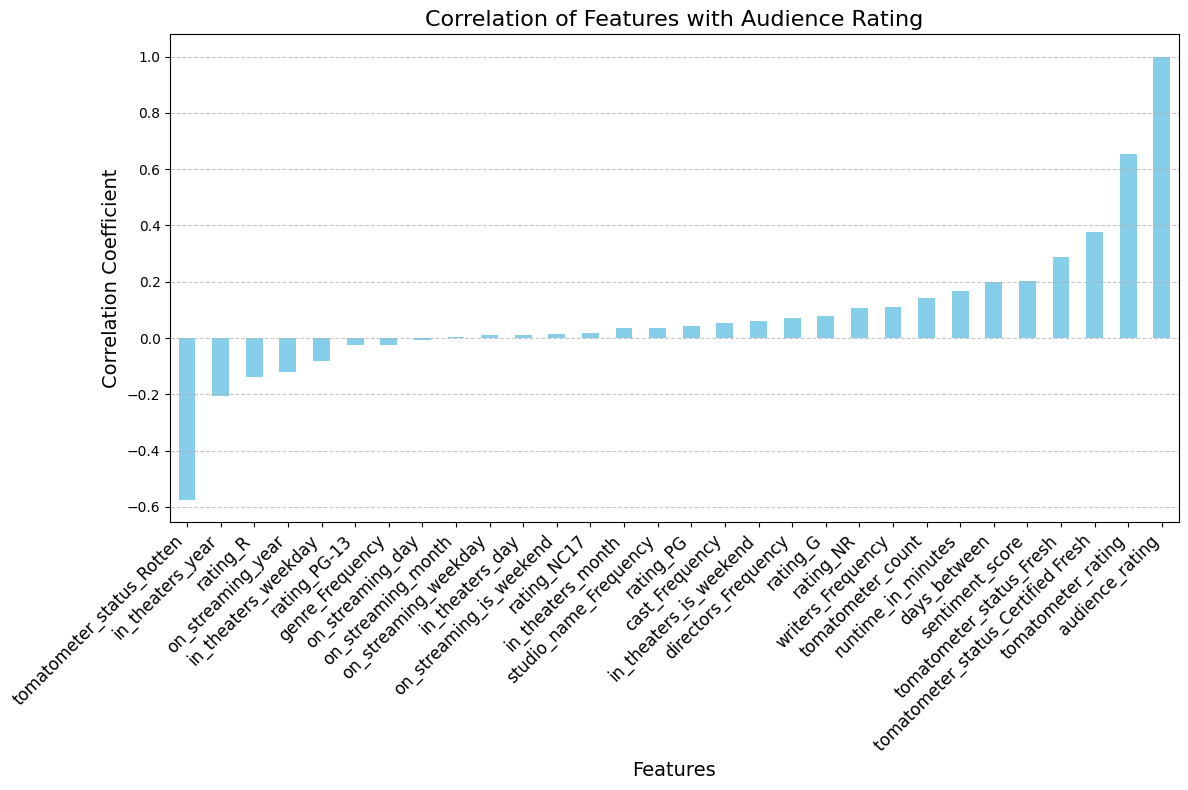

In [12]:
# 6 a) Calculate Pearson correlation of each numerical/categorical feature with target column - 'audience_rating'
#   b) Plot a bar chart to visualize
  
correlation_col_names = ['audience_rating','runtime_in_minutes', 'tomatometer_rating','tomatometer_count','rating_G','rating_NC17',
                         'rating_NR','rating_PG','rating_PG-13','rating_R','genre_Frequency','directors_Frequency','writers_Frequency',
                         'cast_Frequency', 'studio_name_Frequency', 'tomatometer_status_Certified Fresh','tomatometer_status_Fresh',
                         'tomatometer_status_Rotten','sentiment_score','in_theaters_year','in_theaters_month','in_theaters_day',
                         'in_theaters_weekday','in_theaters_is_weekend','on_streaming_year','on_streaming_month','on_streaming_day','on_streaming_weekday','on_streaming_is_weekend','days_between']  # Columns to add from df2
correlation_col = processed_df[correlation_col_names]


# Compute the correlation matrix
correlation_matrix = correlation_col.corr()

# Extract the correlation of each column with the target column
target_column = 'audience_rating' 
target_correlation = correlation_matrix[target_column]

# Sort the correlation values for better visualization
sorted_correlation = target_correlation.sort_values()

# Plot the bar chart
plt.figure(figsize=(12, 8))
sorted_correlation.plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with Audience Rating', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [13]:
# 5 c) The features with medium to high correlation coefficient score are selected: 

selected_df = processed_df.drop(['genre_Frequency','writers_Frequency', 'cast_Frequency', 'studio_name_Frequency',
                                 'in_theaters_month', 'in_theaters_day', 'in_theaters_is_weekend', 'on_streaming_month','audience_rating',
                                 'on_streaming_day', 'on_streaming_weekday', 'on_streaming_is_weekend'],
                                  axis = 1)

#### **6. Normalization:**

In [14]:
def normalize(df,col):
    scaler = MinMaxScaler()
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df

columns_to_normalize = ['runtime_in_minutes','tomatometer_rating','tomatometer_count','directors_Frequency',
                        'in_theaters_weekday','days_between']

X = normalize(selected_df,columns_to_normalize)
Y = df['audience_rating'] 


In [15]:
X.head()

,runtime_in_minutes,tomatometer_rating,tomatometer_count,rating_G,rating_NC17,rating_NR,rating_PG,rating_PG-13,rating_PG-13),rating_R,...,movie_info_embedding_5,movie_info_embedding_6,movie_info_embedding_7,movie_info_embedding_8,movie_info_embedding_9,sentiment_score,in_theaters_year,in_theaters_weekday,on_streaming_year,days_between
0,0.041021,0.49,0.282520,0,0,0,1,0,0,0,...,-0.339297,1.750169,2.415104,-1.532090,-0.252080,0.9274,2010,0.666667,2010,0.209453
1,0.044522,0.86,0.274390,0,0,0,0,0,0,1,...,-0.477878,2.650020,1.920340,-1.016546,-0.702298,0.5023,2010,0.666667,2010,0.210282
2,0.058529,0.68,0.034553,0,0,0,0,0,0,1,...,-0.950668,2.760532,1.599651,-1.443686,-1.425665,0.0000,1979,0.666667,1997,0.361052
3,0.047024,1.00,0.093496,0,0,1,0,0,0,0,...,-1.192957,2.264840,1.397006,-1.187461,-1.352591,0.5423,1957,0.833333,2001,0.586046
4,0.063032,0.89,0.044715,1,0,0,0,0,0,0,...,-1.057773,1.832985,1.414049,-1.924106,-1.414316,0.7579,1954,0.666667,2003,0.633499


#### **7. Model Training:**

In [16]:
# 7 a) Split the data into training,validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Now: 60% train, 20% validation, 20% test
print("Training Set Size:", len(X_train))
print("Validation Set Size:", len(X_val))
print("Test Set Size:", len(X_test))

Training Set Size: 9982
Validation Set Size: 3328
Test Set Size: 3328


In [17]:
# Model 1: Linear Regression

model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print("Evaluating on Validation set:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Evaluating on Validation set:
Mean Squared Error (MSE): 214.56051282459066
Root Mean Squared Error (RMSE): 14.647884243964747
R-squared (R²): 0.4808549983290421


In [18]:
# Model 2: Random Forest Regressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print("Evaluating on Validation set:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Evaluating on Validation set:
Mean Squared Error (MSE): 201.52474025294117
Root Mean Squared Error (RMSE): 14.195940978073315
R-squared (R²): 0.5123960124905053


In [19]:
# Model 3: XGBRegressor

# Initialize and train the XGBoost Regressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print("Evaluating on Validation set:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Evaluating on Validation set:
Mean Squared Error (MSE): 197.68598954088864
Root Mean Squared Error (RMSE): 14.06008497630397
R-squared (R²): 0.521684153251299


Hyperparameter Tuning:

In [20]:
# Using grid search over hyperparameters, find the best parameters for the selected XGBRegressor model

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and the best score
print("Best parameters:", grid_search.best_params_)

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print("Evaluating on Validation set:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Evaluating on Validation set:
Mean Squared Error (MSE): 196.12156636745698
Root Mean Squared Error (RMSE): 14.00434098297585
R-squared (R²): 0.525469390619972


#### **8. Model pipeline:**

In [21]:
#     - Design the model pipeline using the best model with the optimal hyperparameters
#     - Run the model on the test set

# Create the pipeline with the best model (no preprocessing step as it is already processed)
pipeline = Pipeline(steps=[
    ('model', best_model)
])

X_train_final = pd.concat([X_train, X_val], axis=0)
y_train_final = pd.concat([y_train, y_val], axis=0)

pipeline.fit(X_train_final, y_train_final)

# Step 5: Final evaluation on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Evaluating on Test set:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Evaluating on Test set:
Mean Squared Error (MSE): 192.9845888974373
Root Mean Squared Error (RMSE): 13.891889320658919
R-squared (R²): 0.5269151352786827


In [22]:
# Custom Accuracy calculation using MAPE

# Calculate the absolute error
errors = abs(y_pred - y_test)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = 100 * (errors / y_test)

# Calculate the accuracy
accuracy = 100 - np.mean(mape)

print(f" Testing Accuracy: {round(accuracy, 2)} %")

 Testing Accuracy: 75.96 %
